## Getting Started <a class="anchor" id="get-started"></a>

1. Previous experience with `Python` is required. Understanding general machine learning concepts is advisable
1. We will be using `Jupyter` (`jupyter notebook` or `jupyter lab` will work just fine). For a quick intro refer to: [Introduction to Jupyter](jupyter_intro.ipynb)

1. You will also need to have installed few additional libraries: `scikit-learn`, `phe`, `numpy` and `matplotlib`.
    If you don't have them already installed you can do so (using `pip`) by executing the line below:

In [2]:
# install
import sys
!{sys.executable} -m pip install numpy matplotlib phe sklearn

In [3]:
# import libraries
import matplotlib.pylab as plt
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error

import phe as paillier

seed = 42
np.random.seed(seed)

%matplotlib inline

### Understand the data

In [5]:
diabetes = load_diabetes()
y = diabetes.target
X = diabetes.data

print(f'Data consists of {len(X)} diabetes patients')
print(f'and {X.shape[1]} baseline variables:')
print('age, sex, body mass index, average blood pressure, and six blood serum measurements')

Data consists of 442 diabetes patients
and 10 baseline variables:
age, sex, body mass index, average blood pressure, and six blood serum measurements


Target column is a quantitative measure of disease progression one year after baseline

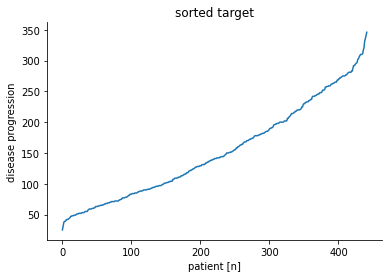

In [7]:
def plot_target(ax, y):
    y_sorted = np.argsort(y)

    ax.set_title('sorted target')
    ax.plot(y[y_sorted])
    ax.set_ylabel('disease progression')
    ax.set_xlabel('patient [n]')

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
ax = plt.subplot(111)
plot_target(ax, y)

In [8]:
# split to test and train datasets

test_size = 50
test_idx = np.random.choice(X.shape[0], size=test_size, replace=False)
train_idx = np.ones(X.shape[0], dtype=bool)
train_idx[test_idx] = False
X_test, y_test = X[test_idx, :], y[test_idx]
X_train, y_train = X[train_idx, :], y[train_idx]

### train the model

In [9]:
class Client:
    """
    Client using linear regression to fit the data
    """
    def __init__(self, name):
        self.name = name
        self.weights = np.zeros(X.shape[1])
    
    def fit(self, X, y, n_iter, eta=0.01):
        """Linear regression for n_iter"""
        for _ in range(n_iter):
            gradient = self.compute_gradient(X, y)
            self.gradient_step(gradient, eta)
    
    def compute_gradient(self, X, y):
        """Compute the gradient of the current model using the training set
        """
        delta = self.predict(X) - y
        return delta.dot(X) / len(X)

    def gradient_step(self, gradient, eta=0.01):
        """Update the model with the given gradient"""
        self.weights -= eta * gradient

    def predict(self, X):
        """Score test data"""
        return X.dot(self.weights)

n_iter = 50
c = Client(name="Hospital")
c.fit(X_train, y_train, n_iter=n_iter, eta=1.5)
y_pred = c.predict(X_test)

In [10]:
mse = mean_squared_error(y_pred, y_test)
print('{:s}:\t{:.2f}'.format(c.name, mse))

Hospital:	27568.95


## split the data between clients

Now we are ready to start adding bits and pieces to create the federated learning.

First, we will split the data to multiple locations. Let's imagine hospitals:

In [11]:
# note: this and most of the following functions are reused from phe example cited above
def get_data(n_clients):
    """
    Import the dataset via sklearn, shuffle and split train/test.
    Return training, target lists for `n_clients` and a holdout test set
    """
    print("Loading data")
    diabetes = load_diabetes()
    y = diabetes.target
    X = diabetes.data
    # Add bias
    X = np.c_[X, np.ones(X.shape[0])]

    # The features are already preprocessed
    # Shuffle
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm, :], y[perm]

    # Select test at random
    test_size = 50
    test_idx = np.random.choice(X.shape[0], size=test_size, replace=False)
    train_idx = np.ones(X.shape[0], dtype=bool)
    train_idx[test_idx] = False
    X_test, y_test = X[test_idx, :], y[test_idx]
    X_train, y_train = X[train_idx, :], y[train_idx]

    # Split train among multiple clients.
    # The selection is not at random. We simulate the fact that each client
    # sees a potentially very different sample of patients.
    X, y = [], []
    step = int(X_train.shape[0] / n_clients)
    for c in range(n_clients):
        X.append(X_train[step * c: step * (c + 1), :])
        y.append(y_train[step * c: step * (c + 1)])

    return X, y, X_test, y_test

In [12]:
# load data, train/test split and split training data between clients
n_clients = 3
Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

Loading data


### store data at the client

Excercise: update the `Client` so that the data is stored in the class. 

In [13]:
# instantiate, train, score the clients
n_iter = 50

for i in range(n_clients):
    c = Client(name="Hospital" + str(i), X=Xs_train[i], y=ys_train[i])
    c.fit(n_iter=n_iter, eta=1.5)
    y_pred = c.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    print('{:s}:\t{:.2f}'.format(c.name, mse))

TypeError: __init__() got an unexpected keyword argument 'X'

In [14]:
def local_learning(n_clients, n_iter=50, eta=1.5):
    # divide the data between n_clients
    Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

    # create n_clients 
    for i in range(n_clients):
        c = Client(name="Hospital" + str(i), X=Xs_train[i], y=ys_train[i])
        c.fit(n_iter=n_iter, eta=eta)
        y_pred = c.predict(X_test)
        mse = mean_squared_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))

n_clients = 3
n_iter = 50
local_learning(n_clients, n_iter)

Loading data


TypeError: __init__() got an unexpected keyword argument 'X'

### aggregate gradients

Excercise: define `federated_learning` function which at each round will receive the calculated gradients from each `Client`, average them together and then pass them back for further training.

In [16]:
def federated_learning(n_clients, n_iter, eta=1.5):
    # divide the data between n_clients
    Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

    # Instantiate the clients.
    ...
    
    for i in range(n_iter):
        gradients = []
        ...
        
    print('Error (MSE) that each client gets after running the protocol:')
    for c in clients:
        y_pred = c.predict(X_test)
        mse = mean_squared_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))

federated_learning(n_clients, n_iter)

Loading data
Error (MSE) that each client gets after running the protocol:


NameError: name 'clients' is not defined

In [18]:
### Homomorphic encryption

In [19]:
def encrypt_vector(public_key, x):
    # encrypt each number separately
    return [public_key.encrypt(i) for i in x]

def decrypt_vector(private_key, x):
    return np.array([private_key.decrypt(i) for i in x])

def sum_encrypted_vectors(x, y):
    # it is possible to sum encrypted vectors
    if len(x) != len(y):
        raise ValueError('Encrypted vectors must have the same size')
    return [x[i] + y[i] for i in range(len(x))]

Excercise: update the client (you can use above functions) by adding encrypted_gradient() function.

In [21]:
class Client:
    """Runs linear regression with local data or by gradient steps,
    where gradient can be passed in.
    Using public key can encrypt locally computed gradients.
    """

    def __init__(self, name, X, y, pubkey=None):
        self.name = name
        self.pubkey = pubkey
        self.X, self.y = X, y
        self.weights = np.zeros(X.shape[1])

    def fit(self, n_iter, eta=0.01):
        """Linear regression for n_iter"""
        for _ in range(n_iter):
            gradient = self.compute_gradient()
            self.gradient_step(gradient, eta)

    def gradient_step(self, gradient, eta=0.01):
        """Update the model with the given gradient"""
        self.weights -= eta * gradient

    def compute_gradient(self):
        """Compute the gradient of the current model using the training set
        """
        delta = self.predict(self.X) - self.y
        return delta.dot(self.X) / len(self.X)

    def predict(self, X):
        """Score test data"""
        return X.dot(self.weights)

    def encrypted_gradient(self, sum_to=None):
        """Compute and encrypt gradient.
        When `sum_to` is given, sum the encrypted gradient to it, assumed
        to be another vector of the same size
        """
        ...

In [22]:
## Define server class

In [23]:
class Server:
    """Private key holder. Decrypts the average gradient"""

    def __init__(self, key_length):
         keypair = paillier.generate_paillier_keypair(n_length=key_length)
         self.pubkey, self.privkey = keypair

    def decrypt_aggregate(self, input_model, n_clients):
        # it only ever gets aggregated gradient so even if it can decrypt the gradient it cannot deduce
        # what data is stored at different clients
        return decrypt_vector(self.privkey, input_model) / n_clients

Excercise: update the federated_learning function to work with the encryption:

In [25]:
def federated_learning(n_clients, n_iter=50, eta=1.5):
    # divide the data between n_clients
    Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

    # Instantiate the server and generate private and public keys
    ...

    # Instantiate the clients.
    # Each client gets the public key at creation and its own local dataset
    clients = []
    ...

    # The federated learning with gradient descent
    print('Running distributed gradient aggregation for {:d} iterations'
          .format(n_iter))
    for i in range(n_iter):

        # Compute gradients, encrypt and aggregate
        ...

        # Send aggregate to server and decrypt it
        ...

        # Take gradient steps
        ...

    print('Error (MSE) that each client gets after running the protocol:')
    for c in clients:
        y_pred = c.predict(X_test)
        mse = mean_squared_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))

In [ ]:
n_clients = 3
n_iter = 50

# first each hospital learns a model on its respective dataset for comparison.
local_learning(n_clients, n_iter=50, eta=1.5)
# and now the full glory of federated learning
federated_learning(n_clients, n_iter=50, eta=1.5)